# IED sequence detection

This notebook detects IEDs and groups them into sequences. This includes:
* Loading an EDF file containing the recordings and keeping a defined subset of all channels.
* Running an IED detection algorithm.
* Grouping IEDs into sequences across channels.
* Doing a basic EDA by producing some plots.

In [4]:
import mne
import scipy
import scipy.io
from scipy import signal
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import seaborn as sns
import math
import pyedflib
from tqdm import tqdm
import pandas as pd
from matplotlib.colors import LogNorm

matplotlib.rcParams['figure.figsize'] = (20, 10)
mne.set_log_level('WARNING')

%run DetectSpike_SEEG.py

Open the file

In [23]:
file_name = 'Data/TrialPatientBeSa/X~ X_74addeec-ea9c-4b25-8280-cab2db067651.EDF'
# file_name = 'Data/TrialPatientArRa/X~ X_2fc7b4bb-d0f1-45b1-b60d-0ec24a942259.EDF'

f = pyedflib.EdfReader(file_name)

Define file specific parameters

In [6]:
freq = 2048

Get channels and number of channels

In [7]:
signal_labels = f.getSignalLabels()

Get list of channels to use from channels.mat

In [5]:
# mat = scipy.io.loadmat('Data/TrialPatientArRa/channels.mat')
# valid_channels = [channel[0] for channel in mat['channels'][:, 0]]

# Load file containing suitable channels and convert to list
df = pd.read_excel('Data/TrialPatientBeSa/BeSA/sub-01/Electrodes.xlsx', header=None)
valid_channels = ['EEG ' + name for name in df[0].tolist()]

Segment the data into blocks of length mins_to_process and detect IEDs in each.

In [40]:
# In minutes
mins_to_process=20

# Time points
M = f.getNSamples()[0]

# Temporarily use an hour of data
M = 2048*60*60

SpikeIds = []
ChanIds = []

# Duration of recording in seconds
NumSecs = M / freq
Blocks = math.floor(NumSecs / (mins_to_process * 60))

# TODO do we loop through final iteration correctly? Depends on Blocks calculation 
# Iterate through each block of mins_to_process minutes
# TODO use full dataset eventually (currently using subset)
for current_block in tqdm(range(4, 40)):

    data_block = np.zeros((len(valid_channels), freq * 60 * mins_to_process))

    # Populate area of data for the current block across all channels
    for i, chan in enumerate(valid_channels):

        data_block[i, :] = f.readSignal(signal_labels.index(chan), \
                                        start = current_block * freq * 60 * mins_to_process, \
                                        n = freq * 60 * mins_to_process)

    # Detect IEDs in current block across all chanels
    SpikeIndex, ChanId, _ = DetectSpikes(data_block, freq, STDCoeff=2)
    
    # Add to list across all blocks, corrected for index of block start
    SpikeIds.append(SpikeIndex + current_block * freq * 60 * mins_to_process)
    ChanIds.append(ChanId)

# Convert to numpy arrays
SpikeIds = np.concatenate(SpikeIds, axis=0)
ChanIds = np.concatenate(ChanIds, axis=0)

100%|██████████| 36/36 [46:54<00:00, 78.18s/it]


Plot histogram of inter-IED intervals.

Text(0.5, 6.79999999999999, 'Time (s)')

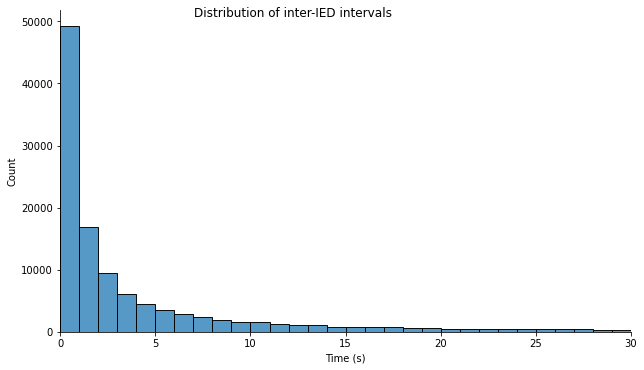

In [163]:
# Difference in time between IEDs
diffs = np.zeros((1))
for channel in np.unique(ChanIds):
    diffs = np.append(diffs, np.diff(SpikeIds[ChanIds == channel]))
    
diffs = diffs[1:]

# Only keep intervals < 30s
filtered_diffs = diffs[diffs / freq < 30]

# Plot using histogram
g = sns.displot(filtered_diffs / freq, bins=30)

g.fig.set_size_inches(10,5)
g.set(xlim=(0, 30))
# g.ax.set_yscale('log')
g.fig.suptitle('Distribution of inter-IED intervals')
plt.xlabel('Time (s)')

Detect IED sequences from individual IED spikes. If an IED is within 50ms of the start of the current sequence, or 15ms from the last added spike in the sequence, it's added to the sequence.

In [122]:
spikes, chans = SpikeIds.copy(), ChanIds.copy()

spikes_argsort = np.argsort(spikes)
spikes = list(spikes[spikes_argsort])
chans = list(chans[spikes_argsort])

# 50ms and 15ms in indices (using known frequency)
fifty_ms = int(round(freq * 0.05))
fifteen_ms = int(round(freq * 0.015))

# Lists for all sequences, one for spike indices and one for channels
all_seq_spikes = []
all_seq_chans = []

# While there are unprocessed spikes 
while len(spikes) > 0:
    
    # Start a list with the leading spike
    seq_spikes = [spikes.pop(0)]
    seq_chans = [chans.pop(0)]
    
    curr_spike = seq_spikes[0]
    
    # For remaining spikes
    for spike in spikes:
        # If spike is within 15ms of last spike in sequence or 50ms of first
        if spike - seq_spikes[0] <= fifty_ms or spike - curr_spike <= fifteen_ms:
            # Then add to sequence
            curr_spike = spike
            
            seq_spikes.append(spikes.pop(0))
            seq_chans.append(chans.pop(0))
            
        # When no more eligible spikes, move to next sequence
        else:
            break
    
    # Add processed sequence to list of sequences
    all_seq_spikes.append(seq_spikes)
    all_seq_chans.append(seq_chans)

Work out the most common routes within IED sequences and display the top 20.

In [123]:
# If a sequence is A -> B -> C, count A -> B as one connection and B -> C as another.
starts_list = [chan[:-1] for chan in all_seq_chans if len(chan) >= 2]
ends_list = [chan[1:] for chan in all_seq_chans if len(chan) >= 2]

pairs = []

for starts, ends in zip(starts_list, ends_list):
    for start, end in zip(starts, ends):
        pairs.append([int(start), int(end)])

unique, counts = np.unique(pairs, return_counts=True, axis=0)

sorted_counts = np.flip(np.argsort(counts))
counts = counts[sorted_counts]
unique = unique[sorted_counts]

for u, c in zip(unique, counts):
    print(c, valid_channels[u[0]], '->', valid_channels[u[1]])

2315 EEG L17 -> EEG L16
2026 EEG L17 -> EEG L18
1803 EEG L18 -> EEG L17
1606 EEG L16 -> EEG L15
1395 EEG L16 -> EEG L17
1278 EEG L18 -> EEG L16
1036 EEG L15 -> EEG L16
907 EEG L16 -> EEG L18
770 EEG K4 -> EEG L6
709 EEG L17 -> EEG L15
619 EEG L15 -> EEG L14
442 EEG F11 -> EEG F10
437 EEG L15 -> EEG L17
416 EEG H10 -> EEG H10
384 EEG L18 -> EEG L15
375 EEG L6 -> EEG L7
342 EEG L6 -> EEG K2
313 EEG L16 -> EEG L14
311 EEG K2 -> EEG L6
310 EEG L14 -> EEG L15
292 EEG L15 -> EEG L18
273 EEG F12 -> EEG F11
265 EEG F11 -> EEG F12
252 EEG F10 -> EEG F11
248 EEG G10 -> EEG G10
243 EEG L15 -> EEG L13
238 EEG K4 -> EEG K2
238 EEG L13 -> EEG L14
215 EEG K4 -> EEG K9
212 EEG L13 -> EEG L15
207 EEG L17 -> EEG L14
204 EEG L14 -> EEG L13
196 EEG L16 -> EEG L13
194 EEG K3 -> EEG K4
189 EEG K9 -> EEG K4
188 EEG L7 -> EEG K4
185 EEG L14 -> EEG L16
180 EEG L6 -> EEG K4
173 EEG K4 -> EEG H10
163 EEG K2 -> EEG L7
161 EEG L14 -> EEG L17
153 EEG L13 -> EEG L16
151 EEG K3 -> EEG L7
148 EEG L18 -> EEG L14
148 EE

7 EEG C4 -> EEG M2
7 EEG L6 -> EEG H2
7 EEG L7 -> EEG L3
7 EEG H6 -> EEG K3
7 EEG C3 -> EEG N10
7 EEG I3 -> EEG H4
7 EEG A1 -> EEG B1
7 EEG L6 -> EEG A13
7 EEG L7 -> EEG L15
7 EEG B3 -> EEG B1
7 EEG L7 -> EEG I2
7 EEG C4 -> EEG B5
7 EEG D6 -> EEG M8
7 EEG D6 -> EEG M9
7 EEG G5 -> EEG L13
7 EEG H10 -> EEG H6
7 EEG M3 -> EEG J2
7 EEG G4 -> EEG G10
7 EEG D7 -> EEG C8
7 EEG L14 -> EEG G5
7 EEG H10 -> EEG F1
7 EEG L14 -> EEG F9
7 EEG D6 -> EEG C4
7 EEG N10 -> EEG D7
7 EEG L3 -> EEG H4
7 EEG N12 -> EEG N13
7 EEG F12 -> EEG K4
7 EEG L3 -> EEG L7
7 EEG H7 -> EEG L15
7 EEG L16 -> EEG A13
7 EEG L6 -> EEG L12
7 EEG B4 -> EEG B2
7 EEG L4 -> EEG K4
6 EEG K2 -> EEG D6
6 EEG F4 -> EEG F2
6 EEG C11 -> EEG C12
6 EEG C4 -> EEG C2
6 EEG H7 -> EEG M3
6 EEG A13 -> EEG D7
6 EEG F11 -> EEG N10
6 EEG B9 -> EEG B8
6 EEG H10 -> EEG I8
6 EEG K2 -> EEG C5
6 EEG J7 -> EEG J8
6 EEG H10 -> EEG M2
6 EEG B1 -> EEG A1
6 EEG I8 -> EEG G5
6 EEG H10 -> EEG N13
6 EEG C2 -> EEG D2
6 EEG F9 -> EEG L15
6 EEG I4 -> EEG L7
6 EE

4 EEG C3 -> EEG D6
4 EEG F11 -> EEG L4
4 EEG F11 -> EEG N11
4 EEG F11 -> EEG N15
4 EEG F12 -> EEG C8
4 EEG F12 -> EEG F13
4 EEG F12 -> EEG G5
4 EEG H7 -> EEG L17
4 EEG F13 -> EEG F12
4 EEG C11 -> EEG C5
4 EEG F12 -> EEG K3
4 EEG F13 -> EEG F10
4 EEG C3 -> EEG D7
4 EEG C12 -> EEG C8
4 EEG C2 -> EEG B8
4 EEG C3 -> EEG B2
4 EEG F9 -> EEG L16
4 EEG G1 -> EEG L7
4 EEG C4 -> EEG J2
4 EEG H6 -> EEG H10
4 EEG C12 -> EEG L17
4 EEG F10 -> EEG A13
4 EEG C2 -> EEG D4
4 EEG C2 -> EEG J7
4 EEG I3 -> EEG I8
4 EEG H6 -> EEG K10
4 EEG C3 -> EEG A7
4 EEG I2 -> EEG L14
4 EEG C3 -> EEG C12
4 EEG F10 -> EEG K4
4 EEG F10 -> EEG K9
4 EEG F10 -> EEG L6
4 EEG I2 -> EEG L6
4 EEG H6 -> EEG L3
4 EEG F10 -> EEG L12
4 EEG I2 -> EEG K2
4 EEG I2 -> EEG J7
4 EEG N15 -> EEG A15
4 EEG C12 -> EEG C10
4 EEG H6 -> EEG N10
4 EEG J8 -> EEG H10
4 EEG J8 -> EEG J7
4 EEG H3 -> EEG L16
4 EEG K4 -> EEG J2
4 EEG C9 -> EEG D7
4 EEG D3 -> EEG M10
4 EEG F1 -> EEG K9
4 EEG D3 -> EEG M3
4 EEG C9 -> EEG D8
4 EEG H2 -> EEG I4
4 EEG D3 ->

3 EEG F2 -> EEG L17
3 EEG D3 -> EEG D4
3 EEG F2 -> EEG N14
3 EEG D2 -> EEG L14
3 EEG F4 -> EEG D6
3 EEG N11 -> EEG D8
3 EEG N10 -> EEG F11
3 EEG F5 -> EEG K10
3 EEG F5 -> EEG L3
3 EEG F5 -> EEG L16
3 EEG F6 -> EEG D2
3 EEG D1 -> EEG L2
3 EEG F6 -> EEG L17
3 EEG D1 -> EEG F2
3 EEG D1 -> EEG D3
3 EEG F9 -> EEG C11
3 EEG N10 -> EEG F10
3 EEG A6 -> EEG C5
3 EEG D1 -> EEG C1
3 EEG F9 -> EEG F5
3 EEG F9 -> EEG F6
3 EEG F9 -> EEG F13
3 EEG D1 -> EEG B5
3 EEG F9 -> EEG H7
3 EEG F9 -> EEG I1
3 EEG D1 -> EEG B2
3 EEG N10 -> EEG F2
3 EEG D2 -> EEG B2
3 EEG N10 -> EEG H6
3 EEG D2 -> EEG C1
3 EEG D2 -> EEG C2
3 EEG F4 -> EEG F5
3 EEG D2 -> EEG K3
3 EEG F4 -> EEG F9
3 EEG F4 -> EEG F11
3 EEG N10 -> EEG L1
3 EEG F4 -> EEG G1
3 EEG F4 -> EEG H4
3 EEG F4 -> EEG L1
3 EEG F4 -> EEG L17
3 EEG F4 -> EEG M4
3 EEG D2 -> EEG F3
3 EEG D2 -> EEG D7
3 EEG A6 -> EEG C8
3 EEG N10 -> EEG I8
3 EEG F5 -> EEG C8
3 EEG N10 -> EEG I3
3 EEG F5 -> EEG C10
3 EEG D2 -> EEG C8
3 EEG D2 -> EEG C4
3 EEG N11 -> EEG D6
3 EEG F1 

2 EEG C5 -> EEG M10
2 EEG F3 -> EEG B5
2 EEG C8 -> EEG F12
2 EEG N10 -> EEG N14
2 EEG G5 -> EEG D6
2 EEG M10 -> EEG C11
2 EEG C8 -> EEG L7
2 EEG L11 -> EEG L5
2 EEG L6 -> EEG F5
2 EEG F3 -> EEG I4
2 EEG B2 -> EEG N13
2 EEG D3 -> EEG A13
2 EEG G5 -> EEG C8
2 EEG C8 -> EEG L3
2 EEG D3 -> EEG A14
2 EEG G5 -> EEG D4
2 EEG G5 -> EEG D5
2 EEG A7 -> EEG M8
2 EEG G5 -> EEG B4
2 EEG G5 -> EEG D8
2 EEG G5 -> EEG F1
2 EEG G5 -> EEG F2
2 EEG N14 -> EEG F1
2 EEG G5 -> EEG F4
2 EEG F3 -> EEG H1
2 EEG G5 -> EEG F9
2 EEG G5 -> EEG F10
2 EEG G5 -> EEG F11
2 EEG G5 -> EEG F12
2 EEG L6 -> EEG D8
2 EEG L6 -> EEG D7
2 EEG M10 -> EEG D1
2 EEG M10 -> EEG D3
2 EEG A8 -> EEG C2
2 EEG L6 -> EEG G3
2 EEG G4 -> EEG K1
2 EEG M10 -> EEG H3
2 EEG M10 -> EEG G5
2 EEG K9 -> EEG N13
2 EEG C8 -> EEG L17
2 EEG G4 -> EEG L3
2 EEG G4 -> EEG L4
2 EEG G4 -> EEG L5
2 EEG M10 -> EEG G3
2 EEG L11 -> EEG L1
2 EEG G4 -> EEG L12
2 EEG G4 -> EEG L13
2 EEG B2 -> EEG N10
2 EEG L15 -> EEG H2
2 EEG A7 -> EEG K10
2 EEG L11 -> EEG L2
2 E

2 EEG G3 -> EEG F10
2 EEG F13 -> EEG K3
2 EEG A7 -> EEG D7
2 EEG L14 -> EEG G1
2 EEG G2 -> EEG N12
2 EEG A6 -> EEG C4
2 EEG N13 -> EEG N11
2 EEG F4 -> EEG F1
2 EEG C9 -> EEG H3
2 EEG G3 -> EEG A7
2 EEG L17 -> EEG L2
2 EEG F4 -> EEG D7
2 EEG G3 -> EEG B1
2 EEG C9 -> EEG G4
2 EEG C9 -> EEG F12
2 EEG K9 -> EEG D5
2 EEG G3 -> EEG F9
2 EEG L15 -> EEG B5
2 EEG G3 -> EEG D3
2 EEG D2 -> EEG L1
2 EEG L15 -> EEG C4
2 EEG D2 -> EEG L2
2 EEG G3 -> EEG D7
2 EEG C9 -> EEG F3
2 EEG M11 -> EEG C3
2 EEG L15 -> EEG C8
2 EEG C9 -> EEG D13
2 EEG F4 -> EEG C8
2 EEG G3 -> EEG F5
2 EEG B2 -> EEG M3
2 EEG A15 -> EEG B3
2 EEG G3 -> EEG L5
2 EEG G4 -> EEG F5
2 EEG F3 -> EEG N10
2 EEG A7 -> EEG G4
2 EEG N14 -> EEG A9
2 EEG C9 -> EEG A1
2 EEG C8 -> EEG N15
2 EEG F3 -> EEG M9
2 EEG C8 -> EEG N13
2 EEG F3 -> EEG M8
2 EEG G4 -> EEG F1
2 EEG L15 -> EEG F3
2 EEG G4 -> EEG F3
2 EEG A6 -> EEG C1
2 EEG N10 -> EEG L15
2 EEG N13 -> EEG N15
2 EEG C8 -> EEG M11
2 EEG B2 -> EEG M10
2 EEG G4 -> EEG F13
2 EEG G4 -> EEG G1
2 EEG

2 EEG K1 -> EEG L11
2 EEG K1 -> EEG L12
2 EEG B1 -> EEG B7
2 EEG L13 -> EEG L11
2 EEG D6 -> EEG M2
2 EEG B9 -> EEG F11
2 EEG D6 -> EEG L18
2 EEG N12 -> EEG L5
2 EEG K1 -> EEG N13
2 EEG K10 -> EEG M2
2 EEG D5 -> EEG N14
2 EEG D6 -> EEG A1
2 EEG K2 -> EEG A7
2 EEG K1 -> EEG I4
2 EEG B9 -> EEG L1
2 EEG N15 -> EEG N10
2 EEG B7 -> EEG J2
2 EEG K1 -> EEG B3
2 EEG K1 -> EEG C1
2 EEG B5 -> EEG K3
2 EEG K1 -> EEG C3
2 EEG B1 -> EEG C3
2 EEG D7 -> EEG B9
2 EEG D7 -> EEG B8
2 EEG D7 -> EEG B7
2 EEG A1 -> EEG B8
2 EEG D7 -> EEG B4
2 EEG B5 -> EEG L3
2 EEG K1 -> EEG F13
2 EEG N12 -> EEG K2
2 EEG K1 -> EEG G1
2 EEG K1 -> EEG G2
2 EEG K1 -> EEG G3
2 EEG K1 -> EEG G4
2 EEG D5 -> EEG N10
2 EEG K1 -> EEG G10
2 EEG K9 -> EEG I4
2 EEG B9 -> EEG L7
2 EEG K1 -> EEG H3
2 EEG K1 -> EEG H4
2 EEG K1 -> EEG H6
2 EEG A14 -> EEG G5
2 EEG L18 -> EEG D2
2 EEG N10 -> EEG F6
2 EEG N14 -> EEG C3
2 EEG L12 -> EEG M8
2 EEG L4 -> EEG A1
2 EEG F1 -> EEG C8
2 EEG M3 -> EEG F12
2 EEG B1 -> EEG J1
2 EEG L16 -> EEG F4
2 EEG L1

1 EEG D2 -> EEG A14
1 EEG D2 -> EEG B1
1 EEG B7 -> EEG K1
1 EEG A1 -> EEG C2
1 EEG A1 -> EEG C3
1 EEG A15 -> EEG M13
1 EEG B7 -> EEG L13
1 EEG B1 -> EEG D3
1 EEG D4 -> EEG I2
1 EEG D5 -> EEG J7
1 EEG D3 -> EEG H4
1 EEG D2 -> EEG G10
1 EEG D3 -> EEG H2
1 EEG B1 -> EEG D7
1 EEG D2 -> EEG H1
1 EEG D5 -> EEG I3
1 EEG A1 -> EEG D3
1 EEG D2 -> EEG H2
1 EEG D2 -> EEG H3
1 EEG D3 -> EEG I2
1 EEG A1 -> EEG D4
1 EEG D4 -> EEG I4
1 EEG A15 -> EEG I4
1 EEG A15 -> EEG M11
1 EEG D2 -> EEG H6
1 EEG D2 -> EEG I1
1 EEG B7 -> EEG K2
1 EEG A1 -> EEG D6
1 EEG D2 -> EEG I2
1 EEG D3 -> EEG I1
1 EEG A1 -> EEG N12
1 EEG B7 -> EEG L11
1 EEG D4 -> EEG G4
1 EEG D5 -> EEG L7
1 EEG D2 -> EEG D8
1 EEG B7 -> EEG L2
1 EEG D5 -> EEG L4
1 EEG D5 -> EEG K9
1 EEG D2 -> EEG F1
1 EEG A1 -> EEG C10
1 EEG D4 -> EEG G3
1 EEG D2 -> EEG F5
1 EEG D5 -> EEG K4
1 EEG B7 -> EEG H6
1 EEG D2 -> EEG F11
1 EEG D2 -> EEG F12
1 EEG D2 -> EEG G2
1 EEG B1 -> EEG L16
1 EEG D2 -> EEG G3
1 EEG A1 -> EEG N11
1 EEG B1 -> EEG L17
1 EEG B1 -> EEG

1 EEG A14 -> EEG N10
1 EEG A8 -> EEG D6
1 EEG A8 -> EEG D8
1 EEG C8 -> EEG B2
1 EEG C8 -> EEG D2
1 EEG B8 -> EEG B1
1 EEG A14 -> EEG M10
1 EEG B8 -> EEG B8
1 EEG B3 -> EEG D4
1 EEG C8 -> EEG B10
1 EEG A8 -> EEG F1
1 EEG C8 -> EEG B5
1 EEG C5 -> EEG L1
1 EEG A8 -> EEG G3
1 EEG C9 -> EEG H4
1 EEG A8 -> EEG H1
1 EEG A8 -> EEG L12
1 EEG C5 -> EEG D13
1 EEG A8 -> EEG L14
1 EEG A8 -> EEG L17
1 EEG A8 -> EEG L18
1 EEG C5 -> EEG C12
1 EEG B3 -> EEG I3
1 EEG A8 -> EEG M3
1 EEG B3 -> EEG K4
1 EEG B7 -> EEG D7
1 EEG B3 -> EEG L7
1 EEG B8 -> EEG B10
1 EEG C5 -> EEG B9
1 EEG B3 -> EEG L11
1 EEG B7 -> EEG D6
1 EEG B8 -> EEG B11
1 EEG C5 -> EEG B7
1 EEG A8 -> EEG M12
1 EEG B3 -> EEG L13
1 EEG C5 -> EEG F4
1 EEG A8 -> EEG L7
1 EEG A8 -> EEG L5
1 EEG B3 -> EEG G2
1 EEG C5 -> EEG K2
1 EEG C5 -> EEG K1
1 EEG A8 -> EEG H3
1 EEG A8 -> EEG H6
1 EEG A8 -> EEG I2
1 EEG A8 -> EEG I8
1 EEG A8 -> EEG J1
1 EEG B3 -> EEG F13
1 EEG C5 -> EEG I4
1 EEG A8 -> EEG L4
1 EEG B3 -> EEG G4
1 EEG B3 -> EEG H2
1 EEG C5 -> EE

1 EEG K10 -> EEG M3
1 EEG K10 -> EEG L18
1 EEG K10 -> EEG L15
1 EEG K10 -> EEG L11
1 EEG K9 -> EEG M1
1 EEG N14 -> EEG C10
1 EEG K9 -> EEG L11
1 EEG K4 -> EEG B5
1 EEG K4 -> EEG K1
1 EEG K4 -> EEG I1
1 EEG N14 -> EEG H2
1 EEG N14 -> EEG H3
1 EEG N14 -> EEG H4
1 EEG N14 -> EEG H6
1 EEG K4 -> EEG H1
1 EEG K4 -> EEG G1
1 EEG N14 -> EEG I3
1 EEG K4 -> EEG F4
1 EEG K4 -> EEG F3
1 EEG K4 -> EEG D6
1 EEG K4 -> EEG C4
1 EEG K4 -> EEG B7
1 EEG K4 -> EEG B4
1 EEG N14 -> EEG G3
1 EEG K4 -> EEG B2
1 EEG K4 -> EEG B1
1 EEG K4 -> EEG A9
1 EEG K4 -> EEG A8
1 EEG K4 -> EEG A1
1 EEG K3 -> EEG N14
1 EEG K3 -> EEG N13
1 EEG K3 -> EEG M8
1 EEG K3 -> EEG M4
1 EEG N14 -> EEG J2
1 EEG K3 -> EEG L2
1 EEG N14 -> EEG K3
1 EEG K3 -> EEG I3
1 EEG K3 -> EEG H2
1 EEG N14 -> EEG G4
1 EEG N14 -> EEG G1
1 EEG K9 -> EEG L1
1 EEG K9 -> EEG C3
1 EEG N14 -> EEG C11
1 EEG N14 -> EEG C12
1 EEG K9 -> EEG I8
1 EEG K9 -> EEG I3
1 EEG K9 -> EEG I2
1 EEG K9 -> EEG H3
1 EEG K9 -> EEG F13
1 EEG K9 -> EEG F9
1 EEG K9 -> EEG F6
1 EE

1 EEG J2 -> EEG H1
1 EEG J2 -> EEG G2
1 EEG F9 -> EEG M2
1 EEG F9 -> EEG J7
1 EEG F9 -> EEG K1
1 EEG F9 -> EEG K10
1 EEG F9 -> EEG L1
1 EEG F9 -> EEG L5
1 EEG F9 -> EEG M1
1 EEG F9 -> EEG M3
1 EEG F9 -> EEG A7
1 EEG F9 -> EEG M9
1 EEG F9 -> EEG M12
1 EEG F9 -> EEG N12
1 EEG F10 -> EEG A6
1 EEG F10 -> EEG A8
1 EEG F10 -> EEG B7
1 EEG F9 -> EEG J2
1 EEG F9 -> EEG J1
1 EEG F9 -> EEG I4
1 EEG F9 -> EEG H6
1 EEG F9 -> EEG H4
1 EEG F9 -> EEG H2
1 EEG F9 -> EEG G10
1 EEG N15 -> EEG I1
1 EEG F9 -> EEG F4
1 EEG F9 -> EEG F2
1 EEG F9 -> EEG D13
1 EEG F9 -> EEG D4
1 EEG F9 -> EEG D3
1 EEG F9 -> EEG C12
1 EEG F9 -> EEG C10
1 EEG F9 -> EEG C8
1 EEG F9 -> EEG B8
1 EEG F10 -> EEG B8
1 EEG F10 -> EEG C2
1 EEG F10 -> EEG D2
1 EEG F10 -> EEG I3
1 EEG F11 -> EEG A7
1 EEG F10 -> EEG N13
1 EEG F10 -> EEG N11
1 EEG F10 -> EEG N10
1 EEG F10 -> EEG M9
1 EEG F10 -> EEG M4
1 EEG F10 -> EEG M3
1 EEG F10 -> EEG M1
1 EEG F10 -> EEG L4
1 EEG F10 -> EEG L1
1 EEG F10 -> EEG K2
1 EEG F10 -> EEG J7
1 EEG F10 -> EEG J1


1 EEG H7 -> EEG F4
1 EEG H7 -> EEG F6
1 EEG H7 -> EEG F12
1 EEG H7 -> EEG F13
1 EEG N15 -> EEG A9
1 EEG I1 -> EEG A15
1 EEG N15 -> EEG A8
1 EEG H7 -> EEG J8
1 EEG H7 -> EEG L1
1 EEG H7 -> EEG L4
1 EEG N15 -> EEG A6
1 EEG H7 -> EEG L12
1 EEG H7 -> EEG D5
1 EEG H7 -> EEG D4
1 EEG H7 -> EEG C11
1 EEG H7 -> EEG C10
1 EEG H7 -> EEG C5
1 EEG H7 -> EEG C4
1 EEG H7 -> EEG C1
1 EEG H7 -> EEG B7
1 EEG H7 -> EEG B4
1 EEG H7 -> EEG B3
1 EEG H7 -> EEG A15
1 EEG H7 -> EEG A6
1 EEG H6 -> EEG N12
1 EEG H6 -> EEG L16
1 EEG H6 -> EEG L15
1 EEG H6 -> EEG L11
1 EEG H6 -> EEG L2
1 EEG H7 -> EEG M1
1 EEG H7 -> EEG M9
1 EEG H7 -> EEG N13
1 EEG H10 -> EEG G2
1 EEG I1 -> EEG A14
1 EEG I1 -> EEG A6
1 EEG N14 -> EEG L13
1 EEG H10 -> EEG N14
1 EEG N14 -> EEG L14
1 EEG N14 -> EEG L15
1 EEG N14 -> EEG L16
1 EEG H10 -> EEG L11
1 EEG N14 -> EEG M3
1 EEG N14 -> EEG M4
1 EEG N14 -> EEG M8
1 EEG N14 -> EEG M9
1 EEG H10 -> EEG I3
1 EEG H10 -> EEG I1
1 EEG H10 -> EEG F5
1 EEG H7 -> EEG N14
1 EEG H10 -> EEG F4
1 EEG H10 ->

Plot a heatmap with the frequency of each connection.

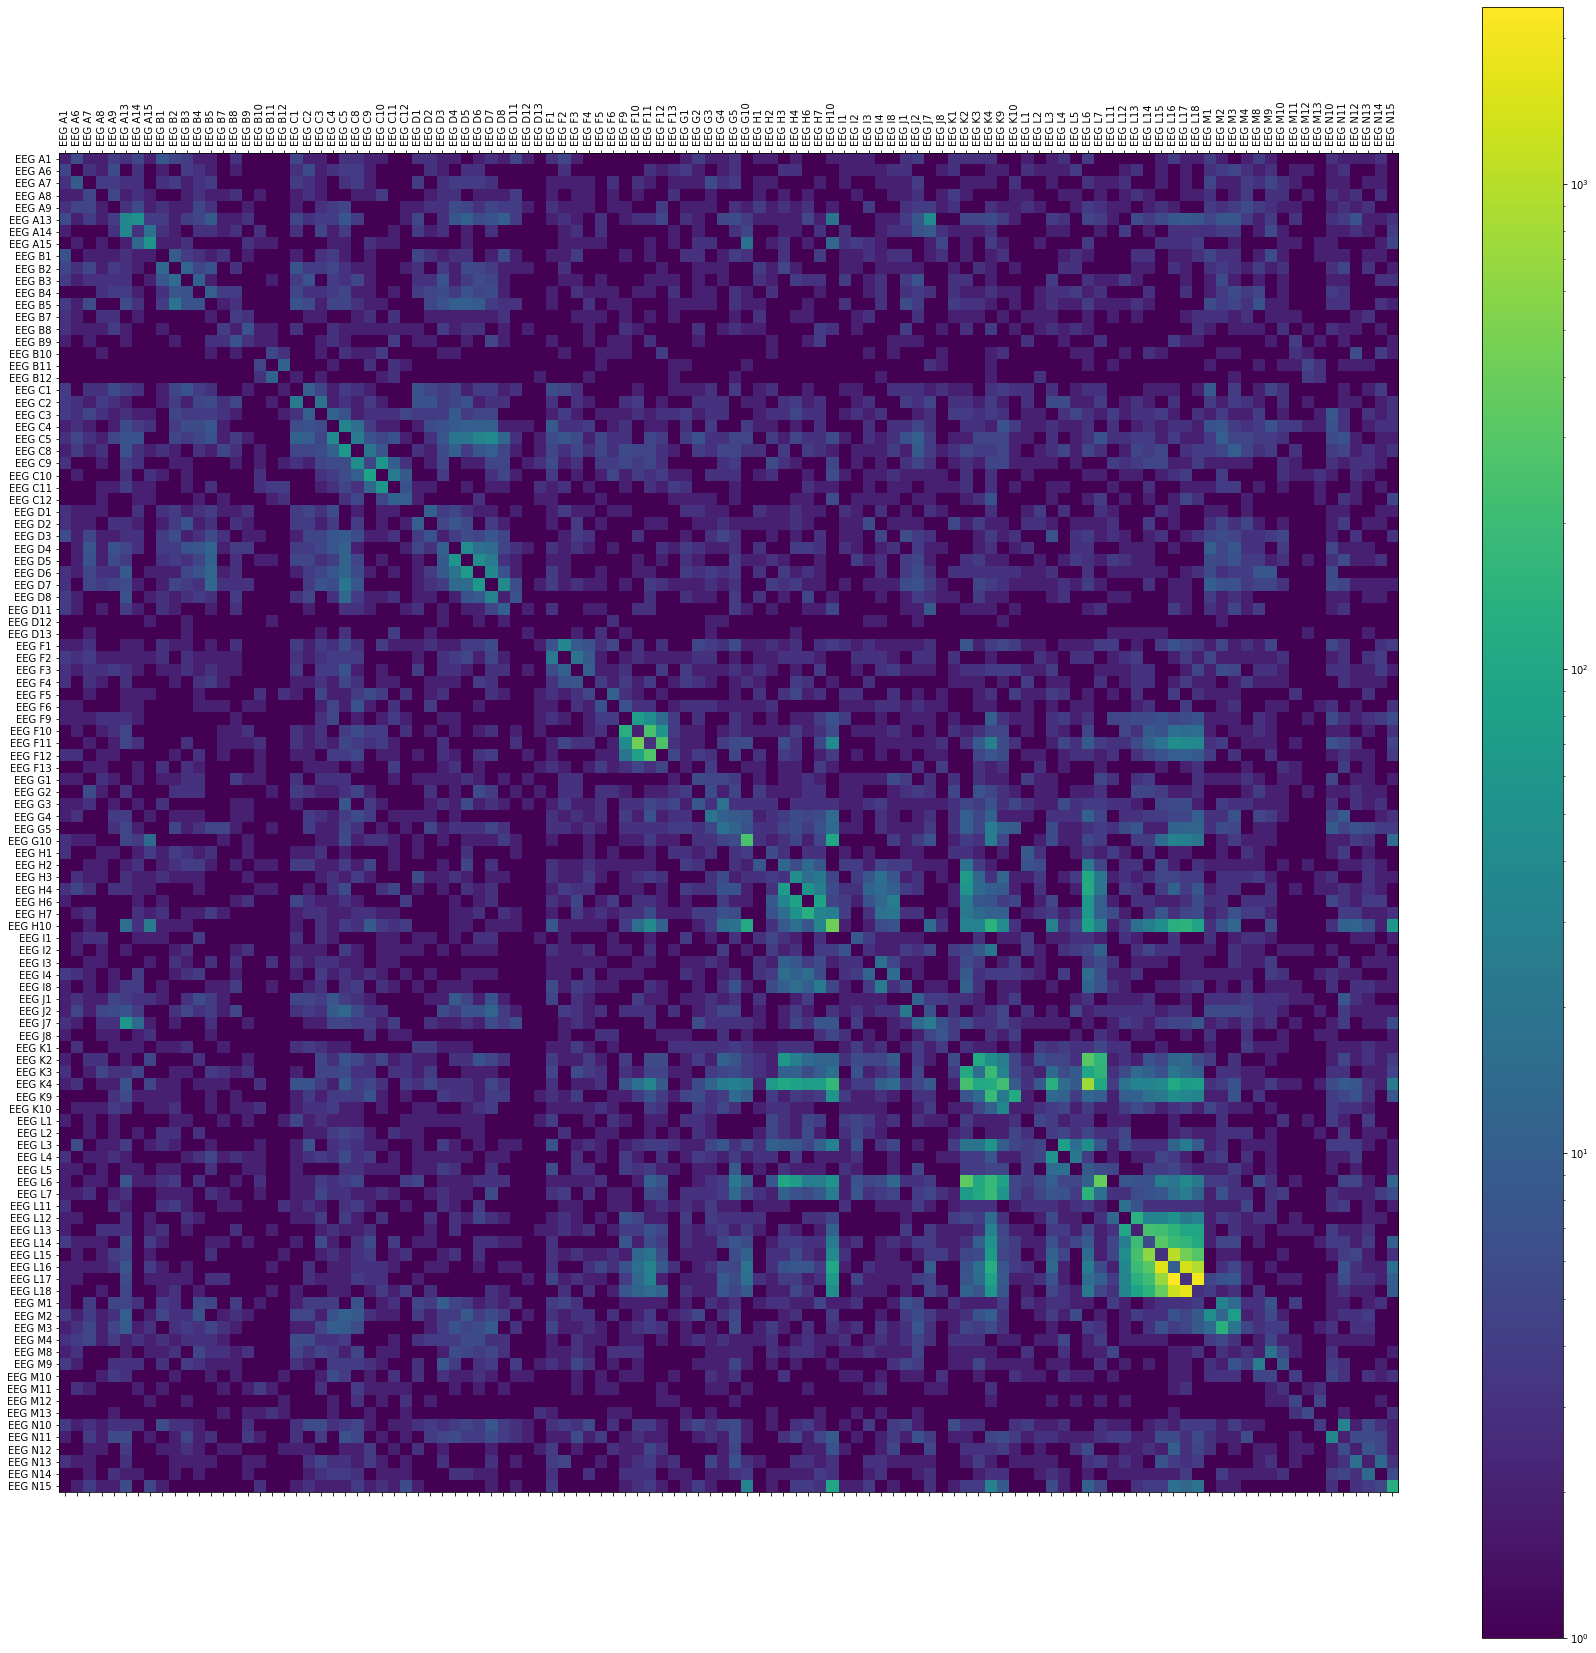

In [174]:
matplotlib.rcParams['figure.figsize'] = (30, 30)

chans = len(valid_channels)

# Produce the matrix
counts_mat = np.zeros((chans, chans))
for c, u in zip(counts, unique):
    counts_mat[u[0]][u[1]] = c

# Display as a heatmap
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(counts_mat + 1, interpolation='nearest', norm=LogNorm())
fig.colorbar(cax)

# Set ticks as appropriate
xaxis = np.arange(chans)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels, rotation=90)
ax.set_yticklabels(valid_channels)

plt.show()

As above but just for one electrode (in this case L).

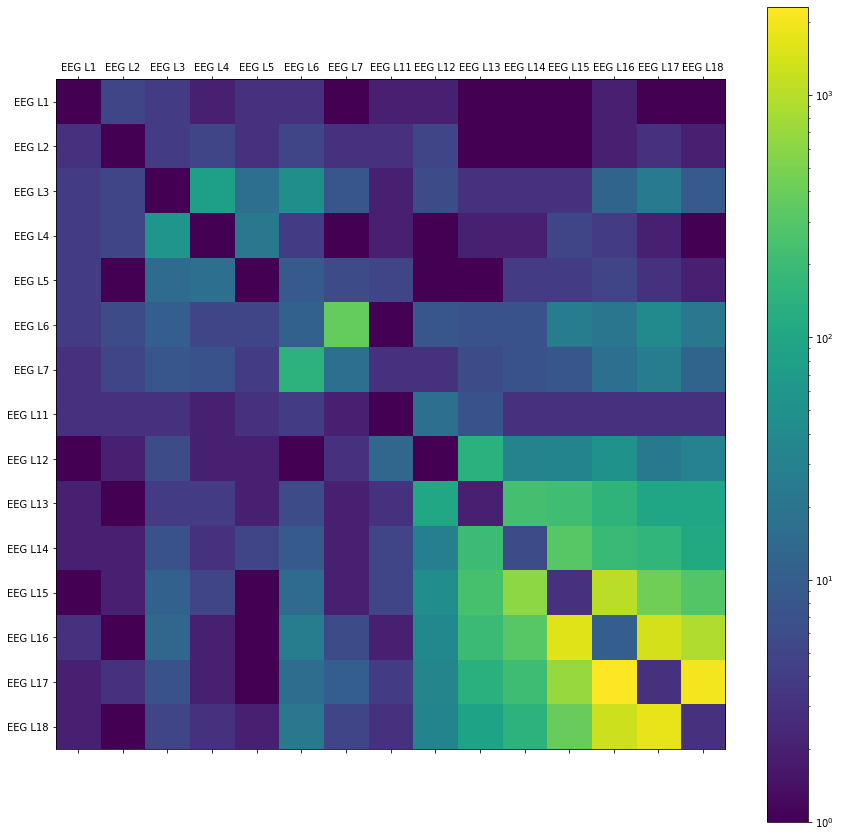

In [176]:
matplotlib.rcParams['figure.figsize'] = (15, 15)

# Get indices of first and last contact on electrode
first_chan_idx = valid_channels.index('EEG L1')
last_chan_idx = valid_channels.index('EEG L18')

# Get slice of original array
subset_counts_mat = counts_mat[first_chan_idx : last_chan_idx + 1, \
                               first_chan_idx : last_chan_idx + 1]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(subset_counts_mat + 1, interpolation='nearest', norm=LogNorm())
fig.colorbar(cax)

xaxis = np.arange(last_chan_idx + 1 - first_chan_idx)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels[first_chan_idx : last_chan_idx + 1])
ax.set_yticklabels(valid_channels[first_chan_idx : last_chan_idx + 1])

plt.show()

Create histogram for IED sequence length

[Text(0.5, 0, 'IED sequence duration (ms)')]

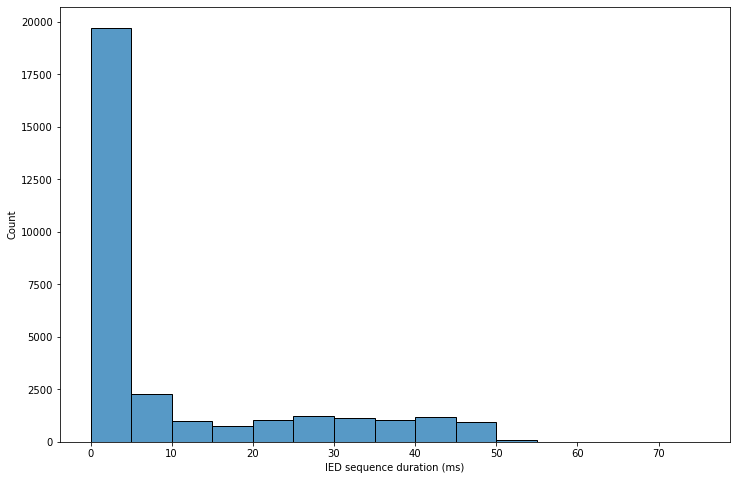

In [46]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

# Work out lengths for each sequence and convert to ms
length_list = [(1000/freq) * (spike[-1] - spike[0]) for spike in all_seq_spikes if len(spike) > 1]

ax = sns.histplot(length_list, bins=15, binrange=[0, 75])
ax.set(xlabel='IED sequence duration (ms)')

Plot histogram of IED frequency over time 

/Users/jamienorris/miniconda3/envs/diss/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/jamienorris/miniconda3/envs/diss/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.04 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

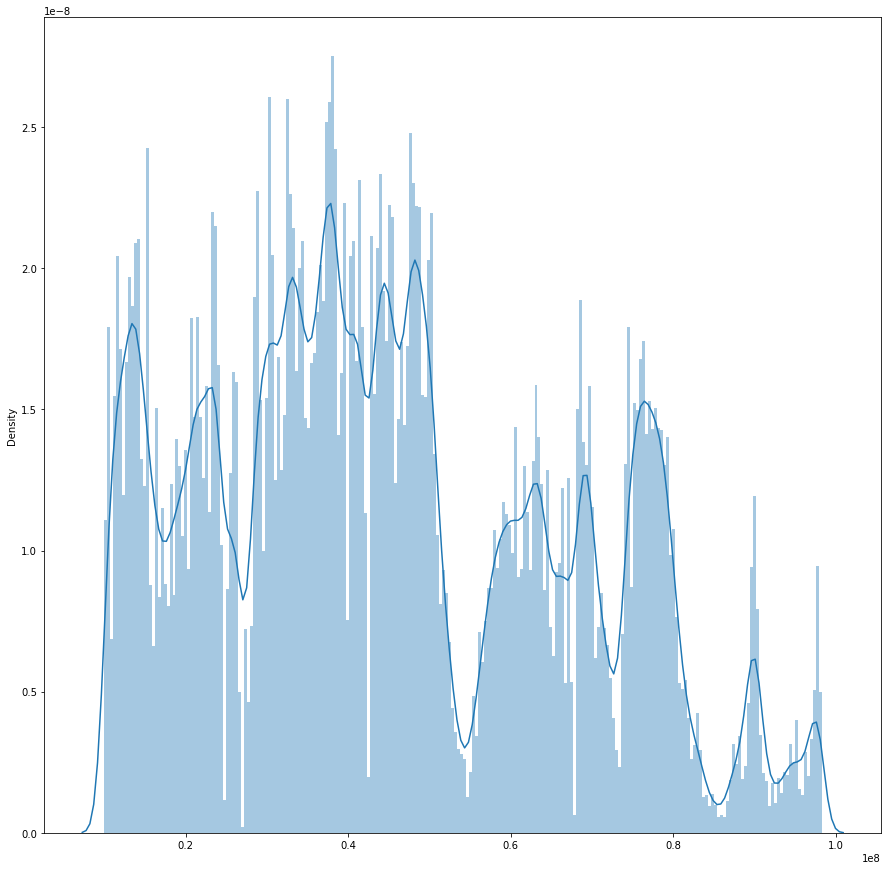

In [178]:
sequence_starts = [spike[0] for spike in all_seq_spikes]
sns.distplot(sequence_starts, bins=240, kde_kws={"bw": 0.04})

Plot histogram of inter-IED intervals, but this time using sequences rather than per-channel

Text(0.5, 6.79999999999999, 'Time (s)')

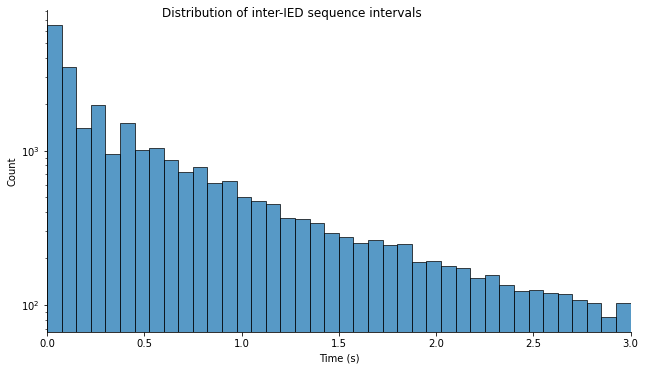

In [49]:
# Difference in time between IEDs
diffs = np.diff(np.array([spikes[0] for spikes in all_seq_spikes if len(spikes) > 1]))

# Only keep intervals < 3s
filtered_diffs = diffs[diffs / freq < 3]

# Plot using histogram
g = sns.displot(filtered_diffs / 2048, bins=40)

g.fig.suptitle('Distribution of inter-IED sequence intervals')
g.fig.set_size_inches(10,5)
g.set(xlim=(0, 3))

# Optionally use log scale
g.ax.set_yscale('log')
plt.xlabel('Time (s)')

Produce a matrix showing the Euclidean distance between each contact in mm

In [179]:
# Define path of positions in voxel space
voxels_path = 'Data/TrialPatientBeSa/BeSA/sub-01/ElectrodesTransformed/'

# Get list of electrodes (ordered)
electrodes = list(dict.fromkeys([channel[4] for channel in valid_channels]))
voxels = {}

# Open each CSV as a pandas dataframe, adding 1 to the index for 1-indexing
for electrode in electrodes:
    voxels[electrode] = pd.read_csv(voxels_path + electrode + \
                                    '_voxel_space.fcsv', delimiter=' ', \
                                    header=None, names=['x', 'y', 'z'])
    voxels[electrode].index += 1
    
    
# Produce the distance matrix
distance_mat = np.zeros((len(valid_channels), len(valid_channels)))

# Iterate through all channels (each is a starting contact)
for i, start in enumerate(valid_channels):
    start_coord = voxels[start[4]].loc[int(start[5:])]
    # Iterate through all channels (distance to each contact, for each start)
    for j, end in enumerate(valid_channels):
        end_coord = voxels[end[4]].loc[int(end[5:])].to_numpy()
        # Calculate Euclidean distance (mm)
        distance_mat[i][j] = np.linalg.norm(start_coord - end_coord)

Plot the distances in a matrix

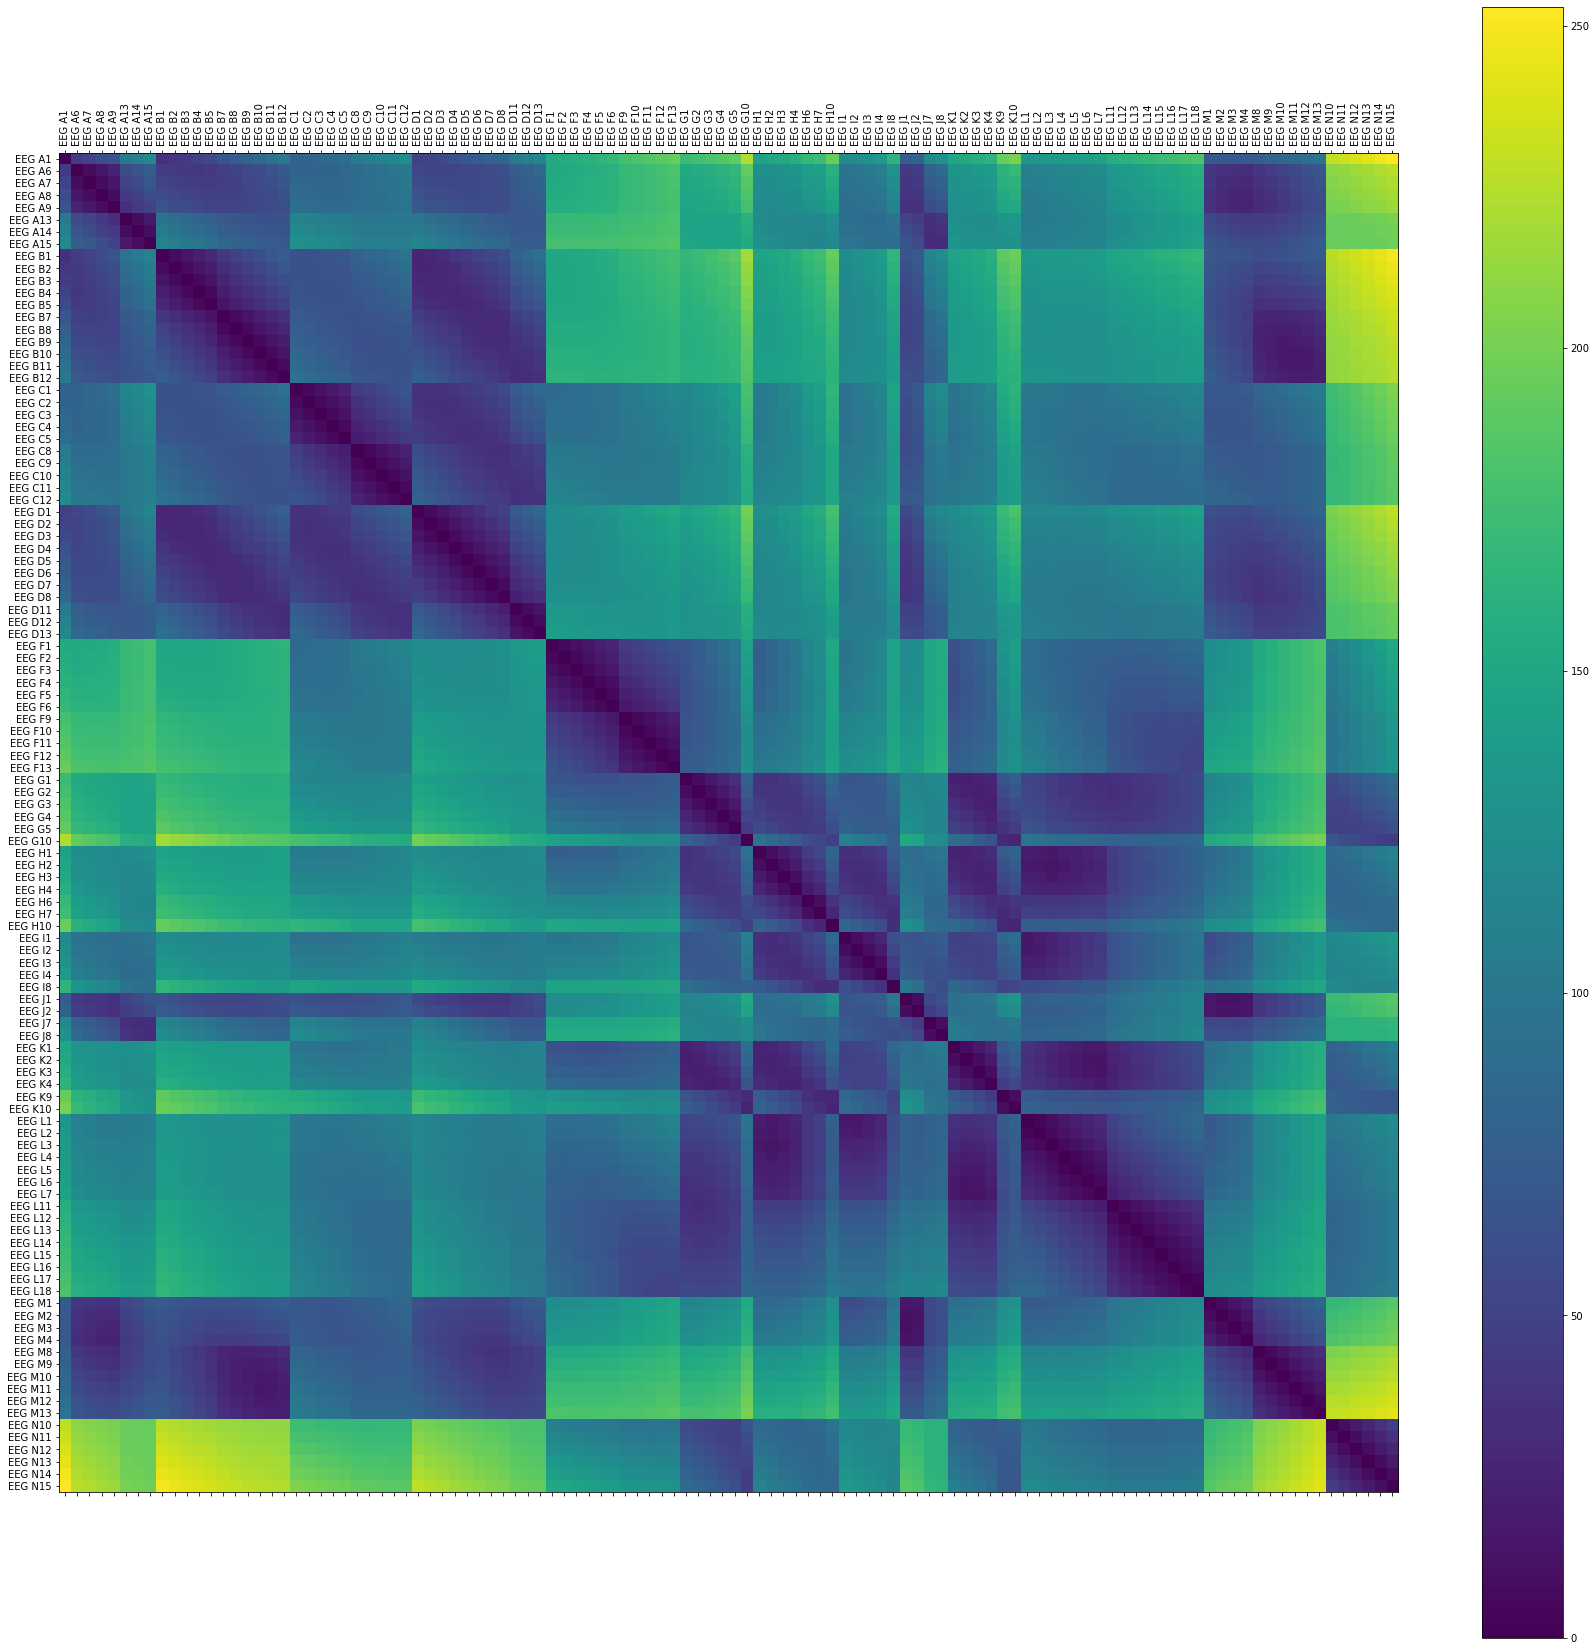

In [182]:
matplotlib.rcParams['figure.figsize'] = (30, 30)

# Display as a heatmap
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(distance_mat, interpolation='nearest')#, norm=LogNorm())
fig.colorbar(cax)

# Set ticks as appropriate
xaxis = np.arange(chans)
ax.set_xticks(xaxis)
ax.set_yticks(xaxis)
ax.set_xticklabels(valid_channels, rotation=90)
ax.set_yticklabels(valid_channels)

plt.show()

May/may not be used in the future, e.g. feature extraction:

In [133]:
# matplotlib.rcParams['figure.figsize'] = (10, 2)

# # How many seconds from the start of the recording to consider
# seconds = 5

# # Index of channel to consider
# chan = 'EEG J9'

# min_start = 30

# signal = f.readSignal(signal_labels.index(chan), \
#                       start = freq * 60 * min_start, \
#                       n = freq * seconds)

# info = mne.create_info([chan], freq, ch_types='seeg')
# data = mne.io.RawArray(data = [signal], info = info)

# onsets = []
# durations = []
# descriptions = []

# SpikeIds_from_zero = SpikeIds - freq * 60 * min_start
# spike_indices = np.logical_and(ChanIds == valid_channels.index(chan), SpikeIds_from_zero < seconds * freq)

# for spike in SpikeIds_from_zero[spike_indices]:
#     if spike > 0:
#         onsets.append(spike / 2048)
#         durations.append(0.01)
#         descriptions.append('IED')

# my_annot = mne.Annotations(onset=onsets,  # in seconds
#                            duration=durations,  # in seconds, too
#                            description=descriptions)

# data = data.set_annotations(my_annot)

# # test = data.plot(start=20, duration=2, n_channels=6, scalings=dict(eeg=5e-4))
# fig = data.plot(scalings=dict(seeg=1e3), 
#                 show_scrollbars=False)
# dt = 0.01
# plt.psd(signal, 512, 1 / dt)
# # ax1.set_xscale('log')

# plt.show()

In [131]:
# from sklearn import preprocessing
# from scipy import signal

# data_scaled = preprocessing.scale(data_block[:, :20480].copy(), axis=1, with_std=True)

# for chan in range(4):
#     hold = data_scaled[chan]
#     f_psd,psd = signal.welch(hold, fs=400, nperseg=2000)
#     psd = np.nan_to_num(psd)
#     psd /= psd.sum()
#     bands=[0.1,4,8,12,30,70,180]

#     for c in range(1,len(bands)):
#         print(f'BandEnergy_0_{chan}_{c}: {psd[(f_psd>bands[c-1])&(f_psd<bands[c])].sum()}')
#     print('')

In [132]:
# for i in range(10):
#     data_scaled = preprocessing.scale(data_block[:, 2048*i:2048*i + 2048].copy(), axis=1, with_std=True)

#     h = np.corrcoef(data_scaled)
#     h = np.nan_to_num(h)
#     ind = np.triu_indices(h.shape[0], 1)
#     htri = h[ind]
    
#     print(f"Mean of correlations: {htri.mean()}")
    
#     c,v = np.linalg.eig(h)
#     c.sort()
#     c = np.real(c)
#     print(f"Top 5 eigenvalues: {c[-5:]}")